## **Model**

### Model Decision Tree (to use as weak learners in AdaBoostClassifier)

In [179]:
import numpy as np
import pandas as pd

def node_score_error(prob):
    '''
        Calculate the node score using the train error of the subdataset and return it.
        For a dataset with two classes, C(p) = min{p, 1-p}
    '''
    return min(prob, 1.0 - prob)

def node_score_entropy(prob):
    '''
        Calculate the node score using the entropy of the subdataset and return it.
        For a dataset with 2 classes, C(p) = -p * log(p) - (1-p) * log(1-p)
        For the purposes of this calculation, assume 0*log0 = 0.
        HINT: remember to consider the range of values that p can take!
    '''
    # HINT: If p < 0 or p > 1 then entropy = 0

    if prob <= 0.0 or prob >= 1.0:
        return 0.0
    
    return -prob * np.log(prob) - (1.0 - prob) * np.log(1.0 - prob)


def node_score_gini(prob):
    '''
        Calculate the node score using the gini index of the subdataset and return it.
        For dataset with 2 classes, C(p) = 2 * p * (1-p)
    '''

    return 2.0 * prob * (1.0 - prob)

class Node:
    '''
    Helper to construct the tree structure.
    '''
    def __init__(self, left=None, right=None, depth=0, index_split_on=0, isleaf=False, label=1):
        self.left = left
        self.right = right
        self.depth = depth
        self.index_split_on = index_split_on
        self.isleaf = isleaf
        self.label = label
        self.info = {}  # used for visualization
        self.threshold = None

    def _set_info(self, gain, num_samples):
        '''
        Helper function to add to info attribute.
        '''
        self.info['gain'] = gain
        self.info['num_samples'] = num_samples


class DecisionTree:

    def __init__(self, data, gain_function=node_score_gini, max_depth=40, weight=None, converted=None):
        # Initialize the decision tree with data and parameters.
        if converted is not None:
            for row in data:
                if row[0] == -1:
                    row[0] = 0  # Convert -1 to 0
                    
        self.majority_class = 1 if sum(row[0] for row in data) > len(data) / 2 else 0
        self.max_depth = max_depth
        self.root = Node(label=self.majority_class)
        self.gain_function = gain_function
        if weight is None:
            self.sample_weight = np.ones(len(data)) / len(data)
        else:
            self.sample_weight = weight / np.sum(weight)

        indices = list(range(1, len(data[0])))
        self._split_recurs(self.root, data, indices, self.sample_weight)

    def predict(self, features, converted=None):
        '''
        Predict the label for given features.
        '''
        if features.ndim == 1:  # 1d array
            prediction = self._predict_recurs(self.root, features)
            return -1 if converted and prediction == 0 else prediction
        else:  # 2d array
            predictions = []
            for feature in features:
                prediction = self._predict_recurs(self.root, feature)
                if converted and prediction == 0:
                    prediction = -1
                predictions.append(prediction)
            return np.array(predictions) 

    def accuracy(self, data):
        '''
        Calculate accuracy on the given data.
        '''
        return 1 - self.loss(data)

    def loss(self, data):
        '''
        Calculate loss on the given data.
        '''
        test_Y = np.array([row[0] for row in data])  # Get the true labels
        predictions = self.predict(np.array(data))  # Get the predicted results
        return np.mean(predictions != test_Y) 

    def _predict_recurs(self, node, row):
        '''
        Predict label by traversing the tree.
        '''
        if node.isleaf or node.index_split_on == 0:
            return node.label
        split_index = node.index_split_on
        if not row[split_index]:
            return self._predict_recurs(node.left, row)
        else:
            return self._predict_recurs(node.right, row)


    def _is_terminal(self, node, data, indices):
        '''
        Check if the node should stop splitting.
        '''
        y = [row[0] for row in data]

        sumy = sum(row[0] for row in data)

        if len(data) - sumy == sumy:
            majority_label = self.majority_class
        else:
            majority_label = 1 if sumy > len(data) / 2 else 0

        if len(set(y)) == 1:
            return True, y[0]
        if len(data) == 0:
            return True, self.majority_class
        if len(indices) == 0:
            return True, majority_label

        if node.depth >= self.max_depth:
            return True, majority_label

        return False, majority_label

    def _split_recurs(self, node, data, indices, weights):
        '''
        Recursively split the node based on data.
        '''
        node.isleaf, node.label = self._is_terminal(node, data, indices)

        if not node.isleaf:
            max_gain = -1
            best_threshold = None

            for split_index in indices:
                feature_values = sorted(set(row[split_index] for row in data))

                for i in range(len(feature_values) - 1):
                    threshold = (feature_values[i] + feature_values[i + 1]) / 2
                    gain = self._calc_gain(data, split_index, self.gain_function, threshold, weights)

                    if gain > max_gain:
                        max_gain = gain
                        node.index_split_on = split_index
                        best_threshold = threshold

                if len(feature_values) == 1:
                    gain = self._calc_gain(data, split_index, self.gain_function, feature_values[0], weights)
                    if gain > max_gain:
                        max_gain = gain
                        node.index_split_on = split_index
                        best_threshold = feature_values[0]

            node._set_info(max_gain, len(data))
            node.threshold = best_threshold

            node.left = Node(depth=node.depth + 1)
            node.right = Node(depth=node.depth + 1)
            indices.remove(node.index_split_on)

            leftData = [row for row in data if row[node.index_split_on] <= node.threshold]
            rightData = [row for row in data if row[node.index_split_on] > node.threshold]

            left_weights = weights[[row[node.index_split_on] <= node.threshold for row in data]]
            right_weights = weights[[row[node.index_split_on] > node.threshold for row in data]]

            self._split_recurs(node.left, leftData, indices, left_weights)
            self._split_recurs(node.right, rightData, indices, right_weights)
        else:
            node._set_info(0, len(data))

    def _calc_gain(self, data, split_index, gain_function, threshold=None, weights=None):
        '''
        Calculate gain for the proposed split.
        '''
        if threshold is None:
            threshold = 0.5
        if weights is None:
            weights = np.ones(len(data))  # Default weights
        y = [row[0] for row in data]
        xi = [1 if row[split_index] > threshold else 0 for row in data]
        
        if len(y) != 0 and len(xi) != 0:
            total_weight = np.sum(weights)
            probY = np.sum(weights * y) / total_weight
            probX = np.sum(weights * xi) / total_weight

            weights = weights.to_numpy() if isinstance(weights, pd.Series) else weights
            y = np.array(y) if not isinstance(y, np.ndarray) else y
            xi = np.array(xi) if not isinstance(xi, np.ndarray) else xi

            y1x1 = sum(weights[index] for index in range(len(y)) if y[index] == 1 and xi[index] == 1)
            y0x0 = sum(weights[index] for index in range(len(y)) if y[index] == 0 and xi[index] == 0)

            prob1 = y1x1 / total_weight 
            prob2 = y0x0 / total_weight 

            probxi_true = (probX * gain_function(prob1 / probX)) if probX > 0 else 0
            probxi_false = ((1.0 - probX) * gain_function(prob2 / (1.0 - probX))) if probX < 1.0 else 0

            gain = gain_function(probY) - probxi_true - probxi_false
        else:
            gain = 0

        return gain

    def print_tree(self):
        '''
        Helper function for tree_visualization.
        Only effective with very shallow trees.
        You do not need to modify this.
        '''
        print('---START PRINT TREE---')
        def print_subtree(node, indent=''):
            if node is None:
                return str("None")
            if node.isleaf:
                return str(node.label)
            else:
                decision = 'split attribute = {:d}; gain = {:f}; number of samples = {:d}'.format(node.index_split_on, node.info['gain'], node.info['num_samples'])
            left = indent + '0 -> '+ print_subtree(node.left, indent + '\t\t')
            right = indent + '1 -> '+ print_subtree(node.right, indent + '\t\t')
            return (decision + '\n' + left + '\n' + right)

        print(print_subtree(self.root))
        print('----END PRINT TREE---')

### Model AdaBoostClassifier

In [180]:
import numpy as np

class AdaBoostClassifier:
    """
    AdaBoost (Adaptive Boosting) Classifier
    An ensemble learning algorithm that combines multiple weak classifiers to build a strong classifier.
    """

    def __init__(self, n_estimators=10, max_depth=1):
        """
        Initialize the AdaBoost classifier.

        Parameters:
        - n_estimators: Number of weak classifiers to use.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth  # Store max_depth for DecisionTree
        self.w = []  # Store the weights of the classifiers
        self.models = []  # Store the weak classifiers
    
    def train(self, X, y):
        """
        Fit the AdaBoost model to the training data.
        For T WLs,
        1. train WL (DecisionTree with max_depth=1)
        2. compute error of this WL
        3. compute the weight of this WL w_t and store it in self.w
        4. compute and update the distribution D of the samples for WLs next

        Parameters:
        - X: Training data, shape (n_samples, n_features)
        - y: Target labels, shape (n_samples,)
        """
        n_samples, n_features = X.shape
        # Initialize weights uniformly
        D = np.ones(n_samples) / n_samples  

        for t in range(self.n_estimators):
            '''
            # sklearn
            # Create a weak classifier (decision stump)
            std_model = DecisionTreeClassifier(max_depth=2)  
            # Fit the model to the training data
            std_model.fit(X, y, sample_weight=D)  # Add this line to train the model
            y_pred_sklearn = std_model.predict(X)
            '''
            # avoid extremely small sample weight
            D = np.clip(D, a_min=np.finfo(D.dtype).eps, a_max=None)

            weak_model = DecisionTree(data=np.column_stack((y, X)), max_depth=self.max_depth, weight=D, converted=True) 
            # weak_model = DecisionTreeClassifier(max_depth=self.max_depth)
            # weak_model.fit(X, y, sample_weight=D) 

            y_pred = weak_model.predict(features=np.column_stack((y, X)), converted = True)
            # y_pred = weak_model.predict(X)

            # Calculate the weighted error
            error = np.mean(np.average(y_pred != y, weights=D, axis=0))

            # Calculate the weight for the weak classifier
            w_t = 0.5 * np.log((1.0 - error) / (error + 1e-10))  # Avoid division by zero

            # Update weights for the next iteration
            D *= np.exp(-w_t * y * y_pred)  # Update weights based on prediction
            D /= np.sum(D * np.exp(-w_t * y * y_pred))  # Normalize weights

            self.models.append(weak_model)  # Store the model
            self.w.append(w_t)  # Store the w_t

    def predict(self, X, converted = True):
        """
        Predict the class labels for the input data.

        Parameters:
        - X: Input data, shape (n_samples, n_features)

        Returns:
        - Predicted class labels, shape (n_samples,)
        """
        pred = np.zeros(X.shape[0])  # Initialize predictions
        X_with_zero = np.insert(X, 0, 0, axis=1)  # Insert 0 at the beginning of each row
        for w_i, model in zip(self.w, self.models):
            pred += w_i * model.predict(X_with_zero, converted)  # Weighted sum of predictions
            # pred += w_i * model.predict(X)
        return np.sign(pred)  # Return the sign of the predictions
    
    def accuracy(self, X, y):
        """
        Calculate the accuracy of the model.

        Parameters:
        - X: Input data, shape (n_samples, n_features)
        - y: True labels, shape (n_samples,)

        Returns:
        - Accuracy as a float.
        """
        predictions = self.predict(X)  # Get predictions
        accuracy = np.mean(predictions == y)  # Calculate accuracy
        return accuracy


## **Check Model**

### Check Adaboost

In [181]:
if __name__ == "__main__":
     # Create a simple dataset
     X = np.array([
        [0, 0, 1, 0],
        [1, 1, 0, 1],
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 1, 0],
        [1, 0, 0, 1],
        [1, 1, 0, 0],
        [0, 0, 1, 1]
    ])  # 10 samples with 4 features

     y = np.array([-1, 1, 1, -1, -1, 1, 1, -1, 1, -1])  # Binary labels (-1 and 1)
     # Initialize the AdaBoost classifier
     model = AdaBoostClassifier(n_estimators=10, max_depth=1)

     # Train the model
     model.train(X, y)

     # Calculate accuracy
     accuracy = model.accuracy(X, y)

     # Print results
     print("Accuracy:", accuracy)

Accuracy: 1.0


In [182]:
import pytest
import numpy as np

# Sets random seed for testing purposes
np.random.seed(0)

# Creates Test Models
test_model1 = AdaBoostClassifier(n_estimators=10)
test_model2 = AdaBoostClassifier(n_estimators=50)
test_model3 = AdaBoostClassifier(n_estimators=20)

# Dataset 1
x1 = np.array([
    [0, 0, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 0],
    [1, 1, 1, 1],
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 1, 0, 0],
    [0, 0, 1, 1]
])  # 10 samples with 4 features

y1 = np.array([-1, 1, 1, -1, -1, 1, 1, -1, 1, -1])  # Binary labels (-1 and 1)

# Dataset 2
x2 = np.array([
    [0, 1, 0, 1, 1, 0],
    [1, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0],
    [0, 1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 0],
    [0, 1, 0, 0, 1, 1]
])  # 10 samples with 6 features

y2 = np.array([-1, 1, 1, -1, 1, -1, 1, -1, 1, -1])  # Binary labels (-1 and 1)

# Dataset 3
x3 = np.array([
    [1, 1, 0, 0, 1, 1],
    [0, 0, 1, 1, 0, 0],
    [1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 1, 1],
    [1, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 0, 1],
    [1, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 1, 0]
])  # 10 samples with 6 features

y3 = np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1])  # Binary labels (-1 and 1)

# Test Model Train
def check_train_dtype(model, X, y):
    assert isinstance(model.models, list)
    assert len(model.models) > 0, "Model should have trained at least one weak learner."
    assert len(model.w) == len(model.models), "Weights should match the number of models."

# Train the models
test_model1.train(x1, y1)
check_train_dtype(test_model1, x1, y1)

test_model2.train(x2, y2)
check_train_dtype(test_model2, x2, y2)

test_model3.train(x3, y3)
check_train_dtype(test_model3, x3, y3)

# Test Model Predictions
def check_test_dtype(pred, X_test):
    assert isinstance(pred, np.ndarray)
    assert pred.ndim == 1 and pred.shape == (X_test.shape[0],)

# Make predictions
pred1 = test_model1.predict(x1)
check_test_dtype(pred1, x1)
assert (pred1 == y1).all(), "Predictions should match the expected labels for model 1."

pred2 = test_model2.predict(x2)
check_test_dtype(pred2, x2)
assert (pred2 == y2).all(), "Predictions should match the expected labels for model 2."

pred3 = test_model3.predict(x3)
check_test_dtype(pred3, x3)
assert (pred3 == y3).all(), "Predictions should match the expected labels for model 3."

# Test Model Accuracy
def check_accuracy(model, X, y, expected_accuracy):
    accuracy = model.accuracy(X, y)
    assert accuracy == expected_accuracy, f"Expected accuracy: {expected_accuracy}, but got: {accuracy}"

# Check accuracy
check_accuracy(test_model1, x1, y1, 1.0)  # Expecting 100% accuracy for this simple case
check_accuracy(test_model2, x2, y2, 1.0)  # Expecting 100% accuracy for this dataset
check_accuracy(test_model3, x3, y3, 1.0)  # Expecting 100% accuracy for this dataset

# Additional Tests for Edge Cases
def test_empty_train():
    with pytest.raises(ValueError):
        test_model1.train(np.array([]), np.array([]))

def test_empty_predict():
    with pytest.raises(ValueError):
        test_model1.predict(np.array([]))

def test_accuracy_empty():
    with pytest.raises(ValueError):
        test_model1.accuracy(np.array([]), np.array([]))

# Run additional edge case tests
test_empty_train()
test_empty_predict()
test_accuracy_empty()

# Print a message indicating the tests have completed
print("All tests completed successfully.")

All tests completed successfully.


### Check Weak Learner

In [183]:
if __name__ == "__main__":
     # Create a simple dataset
    X = np.array([[0, 0], 
              [1, 1], 
              [1, 0], 
              [0, 1], 
              [0, 0], 
              [1, 1]])

    # Corresponding labels
    y = np.array([0, 0, 1, 1, 0, 1]) # Labels should be -1 and 1 for AdaBoost

    # Initialize the AdaBoost classifier
    weak_model = DecisionTree(data=np.column_stack((y, X)), max_depth=4) 
    y_pred = np.zeros_like(y)  # Initialize y_pred
    for i, (y_i, x_i) in enumerate(zip(y, X)):
        combined_input = np.append(y_i, x_i)
        y_pred_i = weak_model.predict(combined_input)  # Predictions from the model
        y_pred[i] = y_pred_i  # Update y_pred with the prediction
    print("y_pred: ", y_pred)

y_pred:  [0 1 1 1 0 1]


In [184]:
if __name__ == "__main__":
     # Create a simple dataset
    X = np.array([[0, 0], 
              [1, 1], 
              [1, 0], 
              [0, 1], 
              [0, 0], 
              [1, 1]])

    # Corresponding labels
    y = np.array([0, 0, 1, 1, 0, 1]) # Labels should be -1 and 1 for AdaBoost

    # Initialize the AdaBoost classifier
    weak_model = DecisionTree(data=np.column_stack((y, X)), max_depth=2) 
    y_pred = np.zeros_like(y)  # Initialize y_pred
    for i, (y_i, x_i) in enumerate(zip(y, X)):
        combined_input = np.append(y_i, x_i)
        y_pred_i = weak_model.predict(combined_input)  # Predictions from the model
        y_pred[i] = y_pred_i  # Update y_pred with the prediction
    print("y_pred: ", y_pred)
    # Make predictions

y_pred:  [0 1 1 1 0 1]


In [185]:
import pytest
import random

np.random.seed(0)
random.seed(0)

# Tests for node_score_error
assert node_score_error(.3) == .3
assert node_score_error(.6) == .4

# Tests for node_score_entropy
assert node_score_entropy(.5) == pytest.approx(.69, .01)
assert node_score_entropy(0) == node_score_entropy(1) == 0
assert node_score_entropy(.7) == pytest.approx(.61,.01)

# Tests for node_score_gini
assert node_score_gini(1) == node_score_gini(0) == 0
assert node_score_gini(.4) == .48

# Creates Test Model and Dummy Data
x = np.array([[0,1,0,0],[1,0,1,1],[1,1,0,1],[0,0,1,0],[0,1,1,1],[0,0,0,0]])
test_model = DecisionTree(x, gain_function=node_score_entropy)

# Test for majority_class
assert test_model.majority_class == 0

# Tests for _is_terminal
node1 = Node(left=None, right=None, depth=0, index_split_on=3, isleaf=False, label=0)
x_filtered_node2 = np.array([row for row in x if row[3] == 1])
node2 = Node(left=None, right=None, depth=1, index_split_on=1, isleaf=False, label=1)
x_filtered_node3 = np.array([row for row in x_filtered_node2 if row[1] == 1])
node3 = Node(left=None, right=None, depth=2, index_split_on=2, isleaf=False, label=0)
x_filtered_node4 = np.array([row for row in x_filtered_node3 if row[2] == 1])
node4 = Node(left=None, right=None, depth=3, index_split_on=None, isleaf=True, label=0)

assert test_model._is_terminal(node=node1, data=x, indices=[1, 2, 3]) == (False, 0)
assert test_model._is_terminal(node=node2, data=x_filtered_node2, indices=[1, 2]) == (False, 1)
assert test_model._is_terminal(node=node3, data=x_filtered_node3, indices=[2]) == (False, 0)
assert test_model._is_terminal(node=node4, data=x_filtered_node4, indices=[]) == (True, 0)

# Tests _calc_gain
# Testing gain for index 3
print("test model", test_model._calc_gain(x, 3, node_score_error))
print("----start-----")
print()
assert test_model._calc_gain(x, 3, node_score_error) == pytest.approx(0.166, .01)

assert test_model._calc_gain(x, 3, node_score_entropy) == pytest.approx(0.318, .01)
assert test_model._calc_gain(x, 3, node_score_gini) == pytest.approx(0.222, .01)

# Testing gain for index 1
assert test_model._calc_gain(x_filtered_node2, 1, node_score_error) == pytest.approx(5.551115123125783e-17, abs=1e-18)
assert test_model._calc_gain(x_filtered_node2, 1, node_score_entropy) == pytest.approx(0.174, .01)
assert test_model._calc_gain(x_filtered_node2, 1, node_score_gini) == pytest.approx(0.111, .01)

# Testing gain for index 2
assert test_model._calc_gain(x_filtered_node3, 2, node_score_error) == pytest.approx(0.5, .01)
assert test_model._calc_gain(x_filtered_node3, 2, node_score_entropy) == pytest.approx(0.693, .01)
assert test_model._calc_gain(x_filtered_node3, 2, node_score_gini) == pytest.approx(0.5, .01)

# Check Tree is created Properly, Compare with text below
'''
Decision Trees should look similar to below (the second one is the pruned tree)

---START PRINT TREE---
split attribute = 3; gain = 0.318257; number of samples = 6
0 -> False
1 -> split attribute = 1; gain = 0.174416; number of samples = 3
		0 -> True
		1 -> split attribute = 2; gain = 0.693147; number of samples = 2
				0 -> True
				1 -> False
----END PRINT TREE---
'''
test_model.print_tree()

# check loss
print('training loss:', test_model.loss(x))
x_val = np.array([[1,1,1,1],[1,0,0,1]])
print('validation loss:', test_model.loss(x_val), '\n')

test model 0.16666666666666663
----start-----

---START PRINT TREE---
split attribute = 3; gain = 0.318257; number of samples = 6
0 -> 0
1 -> split attribute = 1; gain = 0.174416; number of samples = 3
		0 -> 1
		1 -> split attribute = 2; gain = 0.693147; number of samples = 2
				0 -> 1
				1 -> 0
----END PRINT TREE---
training loss: 0.0
validation loss: 0.5 



## **Apply to Previous Work**

### Introduction to Previous Work

For previous work, we choose **scikit-learn's implementation of AdaBoost (AdaBoostClassifier)** with a shallow decision tree (DecisionTreeClassifier) as the base estimator.
We apply scikit-learn's AdaBoost model to the **mushroom dataset**("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"), which comprises 23 binary features describing mushroom characteristics, such as shape, color, and odor, with a binary target indicating edibility (-1 for edible, 1 for poisonous). The model achieves high accuracy, demonstrating the power of AdaBoost in correctly classifying tumors. Below is the code:

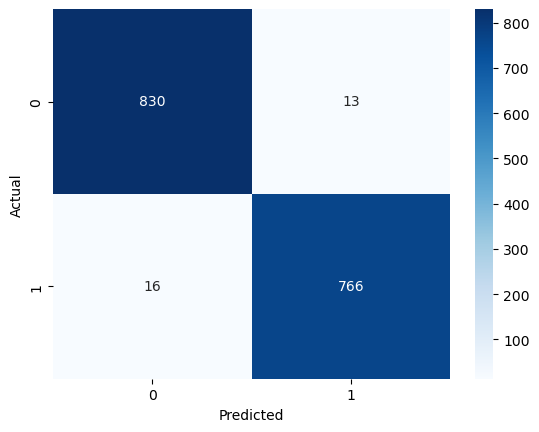

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98       843
           1       0.98      0.98      0.98       782

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625

Model accuracy:  0.9821538461538462


In [186]:
# Load the Mushroom Dataset from UCI repository
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier as AdaBoostClassifier_sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# URL for Mushroom dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Column names for the dataset as per UCI documentation
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat"
]

# Load dataset
mushroom_data = pd.read_csv(url, header=None, names=columns)

# Preprocess the data
# Convert categorical variables into binary using one-hot encoding
# Convert 'class' column (edible=e, poisonous=p) into binary labels
mushroom_data["class"] = mushroom_data["class"].apply(lambda x: 1 if x == "p" else -1)
mushroom_data_encoded = pd.get_dummies(mushroom_data.drop(columns=["class"]))

# Combine the binary features with the target
mushroom_dataset = pd.concat([mushroom_data["class"], mushroom_data_encoded], axis=1)

X = mushroom_dataset.drop(columns=["class"])
y = mushroom_dataset["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost = AdaBoostClassifier_sklearn(estimator=base_estimator, algorithm='SAMME', n_estimators=10, learning_rate=1, random_state=42)

# Train AdaBoost classifier
adaboost.fit(X_train, y_train)

# Making predictions
y_pred = adaboost.predict(X_test)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Calculate accuracy
accuracy = adaboost.score(X_test, y_test)
print("Model accuracy: ", accuracy)

### Reproduce previous work using our model

To reproduce the previous work, we simply replace AdaBoostClassifier_sklearn from sklearn in previous work with our implemented model AdaBoostClassifier. Below is the code:

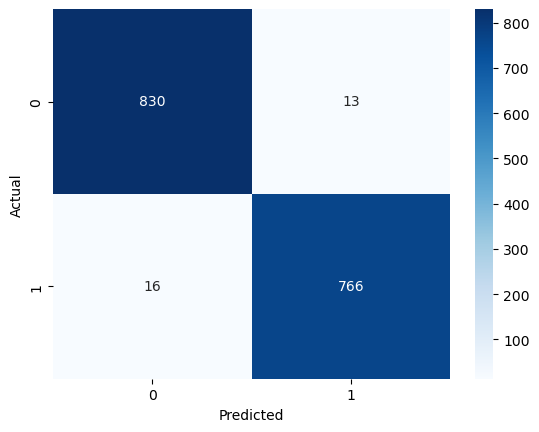

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98       843
           1       0.98      0.98      0.98       782

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625

Model accuracy:  0.9821538461538462


In [187]:
# URL for Mushroom dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Column names for the dataset as per UCI documentation
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat"
]

# Load dataset
mushroom_data = pd.read_csv(url, header=None, names=columns)

# Preprocess the data
# Convert categorical variables into binary using one-hot encoding
# Convert 'class' column (edible=e, poisonous=p) into binary labels
mushroom_data["class"] = mushroom_data["class"].apply(lambda x: 1 if x == "p" else -1)
mushroom_data_encoded = pd.get_dummies(mushroom_data.drop(columns=["class"]))

# Combine the binary features with the target
mushroom_dataset = pd.concat([mushroom_data["class"], mushroom_data_encoded], axis=1)

X = mushroom_dataset.drop(columns=["class"])
y = mushroom_dataset["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
adaboost = AdaBoostClassifier(n_estimators=10, max_depth=1)
adaboost.train(X_train, y_train)

# Making predictions
y_pred = adaboost.predict(X_test)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Calculate accuracy
accuracy = adaboost.accuracy(X_test, y_test)
print("Model accuracy: ", accuracy)

We can see that our own implemented model reproduces the same results from the sklearn model.